

# Proyecto

### Equipo:

- Sebastian Avendaño
- Felipe Urrutia

- \<Nombre de usuarios en Codalab\>

- \<Nombre del Equipo en Codalab\>

### Link de repositorio de GitHub: https://github.com/furrutiav/lab-mds-2022



## 0. Librerías Utilizadas

In [1]:
# Carga y Preparación de los datos

import pickle
import pandas as pd
import numpy as np
#!pip install pyarrow

# EDA

import datetime as dt
import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.preprocessing import MinMaxScaler
from pandas_profiling import ProfileReport

C:\Users\Sebastian\.conda\envs\mds7202\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## 1. Introducción

El objetivo de este proyecto consiste en ...

Los datos que proveen es un dataset con X ejemplos que describen una observación de ... 
Son N atributos y la variables objetivos son de tipo ... y ...

La primera tarea se evalua en base a la métrica ... ya que esta permite medir ...

Nuestra propuesta para resolver el problema consistió en modelo de clasificación basado en...

Nuestro modelo cumplió/no cumplió las expectativas...

---
## 2. Carga y Preparación de los Datos

Cargar los datos con Pandas

In [2]:
# datos: train_numerical_features.parquet y train_text_features.parquet
train_numerical_features = pd.read_parquet('train_numerical_features.parquet').set_index("id")
train_text_features = pd.read_parquet('train_text_features.parquet').set_index("id")

Fusionar por id

In [3]:
df = pd.concat([train_numerical_features, train_text_features], axis=1)

Eliminar columnas duplicadas

In [4]:
df = df.T.drop_duplicates().T

Eliminar columnas 'poster_path', 'backdrop_path', 'recommendations'

In [5]:
df = df.drop(columns=['poster_path', 'backdrop_path', 'recommendations'])

Filtrar ejemplos con revenue igual a 0.

In [6]:
df = df[df["revenue"]>0]

Filtrar ejemplos con release_date y runtime nulos.

In [7]:
df["release_date"].isna().sum()

0

In [8]:
df["runtime"].isna().sum()

0

Convertir fechas de release_date a pd.DateTime

In [9]:
df["release_date"] = df["release_date"].apply(pd.to_datetime)

Conservar solo los ejemplos con status "Released"

In [10]:
df = df[df["status"] == "Released"]

Rellenar valores nulos categóricos y de texto con ' '

In [11]:
df[train_text_features.columns.tolist()] = df[train_text_features.columns.tolist()].fillna("")

Discretizar vote_average a los siguientes bins y guardar los resultados en la columna label:

    (0, 5]: 'Negative'
    (5, 6]: 'Mixed'
    (6, 7]: 'Mostly Positive'
    (7, 8]: 'Positive'
    (8, 10]: 'Very Positive'


In [12]:
df["label"] = pd.cut(df['vote_average'], 
       bins=[0,5,6,7,8,10], 
       labels=["Negative", "Mixed", "Mostly Positive", "Positive", "Very Positive"])

Eliminar la columna vote_average e id

In [13]:
df = df.drop(columns="vote_average")
df = df.reset_index(drop=True)

Renombrar la columna revenue por target

In [14]:
df = df.rename(columns={"revenue": "target"})

## 3. Análisis Exploratorio de Datos (EDA)

### Análisis Univariable

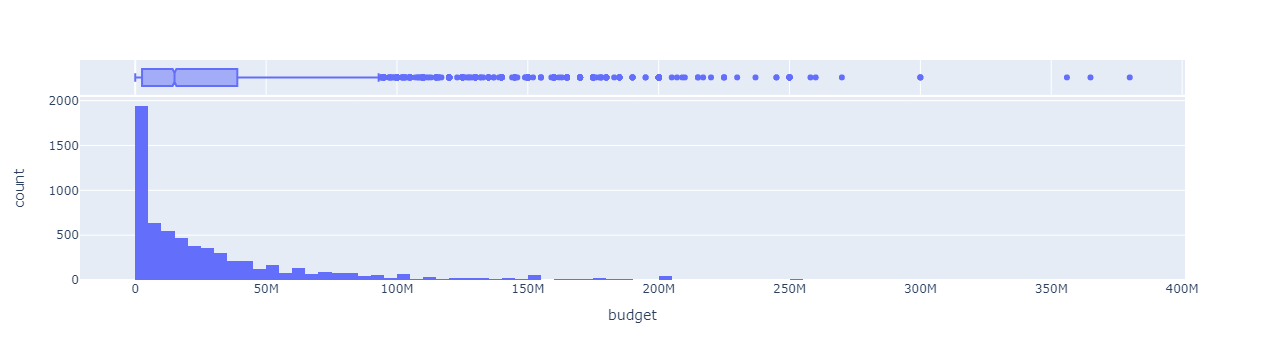

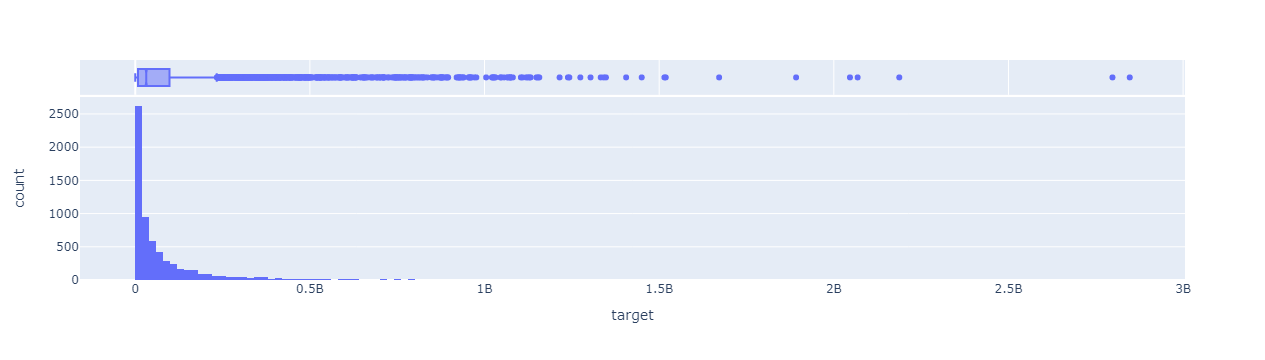

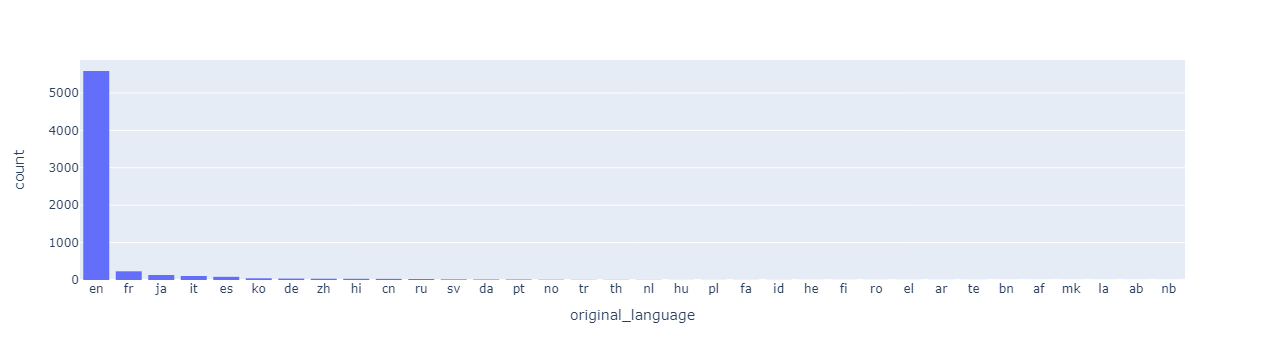

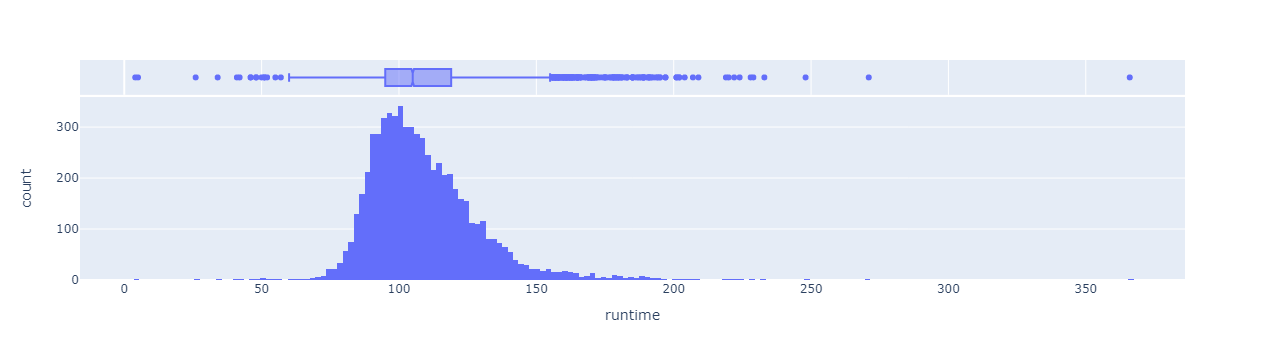

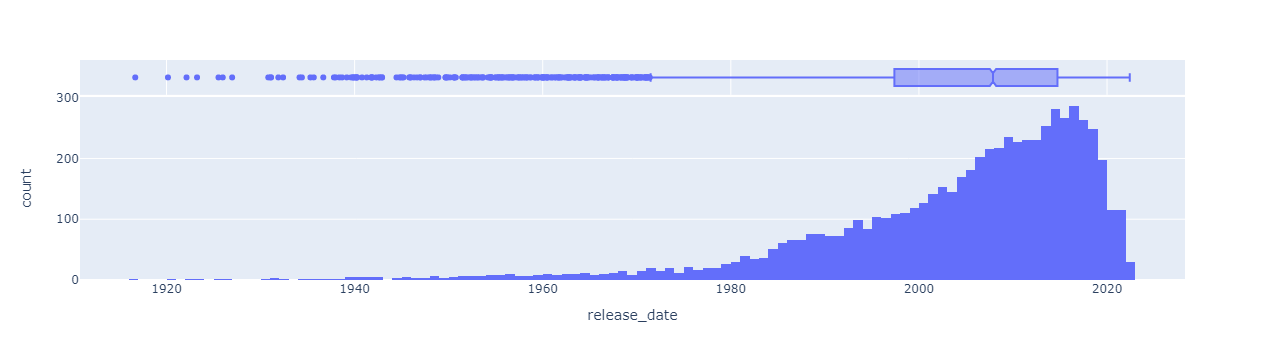

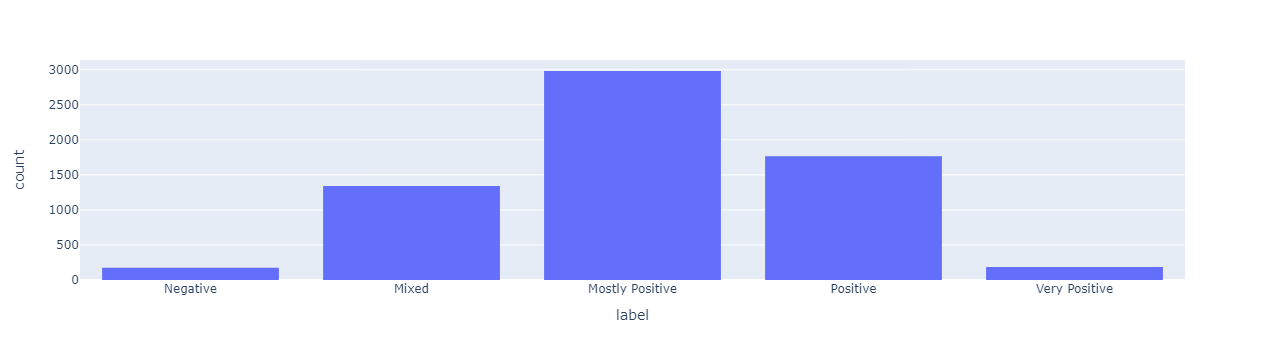

In [15]:
for i in [1,2,8,3,11,13]:
    if i==8:
        fig = px.histogram(df, x=list(df.columns)[i])
        fig.update_xaxes(categoryorder="total descending")
    else:
        if i==13:
            fig = px.histogram(df, x=list(df.columns)[i])
            cat_array=["Negative", "Mixed", "Mostly Positive", "Positive", "Very Positive"]
            fig.update_xaxes(categoryorder="array", categoryarray=cat_array)
        else:
            fig = px.histogram(df, x=list(df.columns)[i], marginal='box')
    fig.show()

In [16]:
# DataFrame con variables numéricas
numeric = ["budget",
           "target",
           "runtime",
           "release_date"]

df_num = df[numeric].copy()
df_num.loc[:,"release_date"] = df_num["release_date"].apply(lambda x: x.timestamp())
# asimetría de release_date
df_num['release_date'].skew()

-1.6836044031005333

#### Comportamientos:

- budget: Presenta una alta crecida al inicio, explicado por la alta cantidad de ceros de esta variable (17,3\% según pandas profiling). En primera instancia podría intuirse que esta variable distribuye log-normal, debido a su asimetría positiva (skewness=2.57). Según el gráfico de caja adjunto, se puede observar alta cantidad de outliers a partir del valor 94M USD.

- target: De forma similar a budget, una alta crecida al inicio, pero aquí no se observan ceros. Puede deberse a una alta cantidad de películas que consiguen pocas ganancias, pero además, a que el dominio de la variable es mucho más amplip que budget, llegando a los 2.8 B USD, generando una asimetría aún más positiva (skewness=4.95). Según el gráfico de caja adjunto, se puede observar alta cantidad de outliers a partir del valor 233M USD.

- orinigal_language: Distribución con una alta concentración en el idioma inglés (86.6%). El segundo idioma que le sigue es francés con un 3.6%. Los demás idiomas no son tan frecuentes, pudiendo corresponder con la cantidad de películas locales de las regiones donde se hablen esos idiomas.

- runtime: Se asemeja a una distribución normal, pero presenta asimetría positiva (skewness=1.56). Se observa alta cantidad de outliers en ambas direcciones, pero con mayor número hacia la derecha, es decir, valores mayores de "runtime".

- release_date: En este caso se tiene una asimetría negativa (skewness=-1.68, al ordenar las fechas por sus "timestamps"). Alta cantidad de outliers para fechas anteriores a mayo de 1971. Es una distribución esperable debido a que la industria del cine está condicionada por el avance de la tecnología en producción audiovisual.

- label: Al ordenar las valoraciones, se obtiene una distribución simétrica, similar a una normal.

### Análisis Multivariable mediante Scatter Plot Matrix

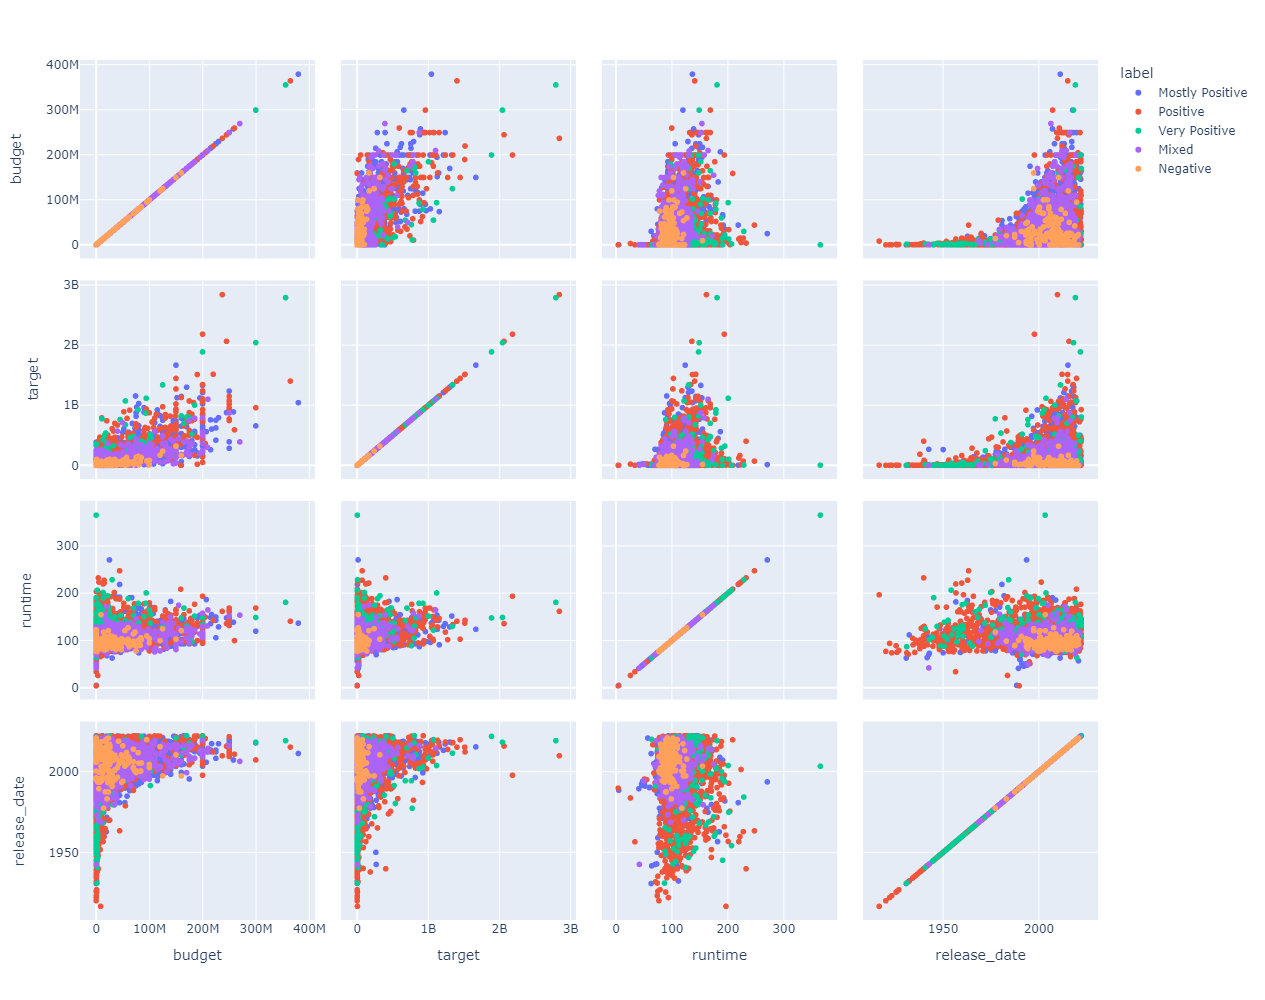

In [17]:
fig = px.scatter_matrix(
    df,
    height=1000,
    dimensions = numeric,
    color="label",
)
fig.show()

#### Comportamientos destacables:

- Gráfico Budget vs Target: Se observa un comportamiento de correlación positiva entre las variables. Además, también está presente una correlación positiva entre las variables y "labels", en colores. Aunque también se observa la existencia de películas con label "negative" pero con alto "budget", además de que las películas con una valoración "very positive" se puede encontrar en toda el área del gráfico. 

- Gráfico runtime vs release_date: Se observa que las películas con valoración negativa están bien agrupadas en un sector del gráfico, y esta área es, para los "runtime" al rededor de 100 min y "release_date" desde los 90 en adelante. Ocurre algo similar con las películas de etiqueta "mixed". Por otro lado, las películas de valoración "positive" se distribuyen a lo largo de "release_date", aunque en "runtime" tienden a agruparse hacia los 100 min.

- Gráficos runtime vs taget y runtime vs budget: Se observa una distribución similar a una normal para todas las etiquetas, por lo que se intuye que la correlación entre runtime y target o runtime y budget no es fuerte.

- Gráficos release_date vs taget y release_date vs budget: Se observa en ambos gráficos una distribución con asimetría positiva, que podría explicarse por el mismo comportamiento univariado de release_date, por lo que en este caso también se intuye que las correlaciones no son fuertes. 

### Correlaciones y Valores Faltantes

In [18]:
corrmat = df_num.astype('float64').corr()
corrmat

budget    target   runtime  release_date
budget        1.000000  0.734250  0.256811      0.189784
target        0.734250  1.000000  0.238013      0.113080
runtime       0.256811  0.238013  1.000000     -0.054074
release_date  0.189784  0.113080 -0.054074      1.000000

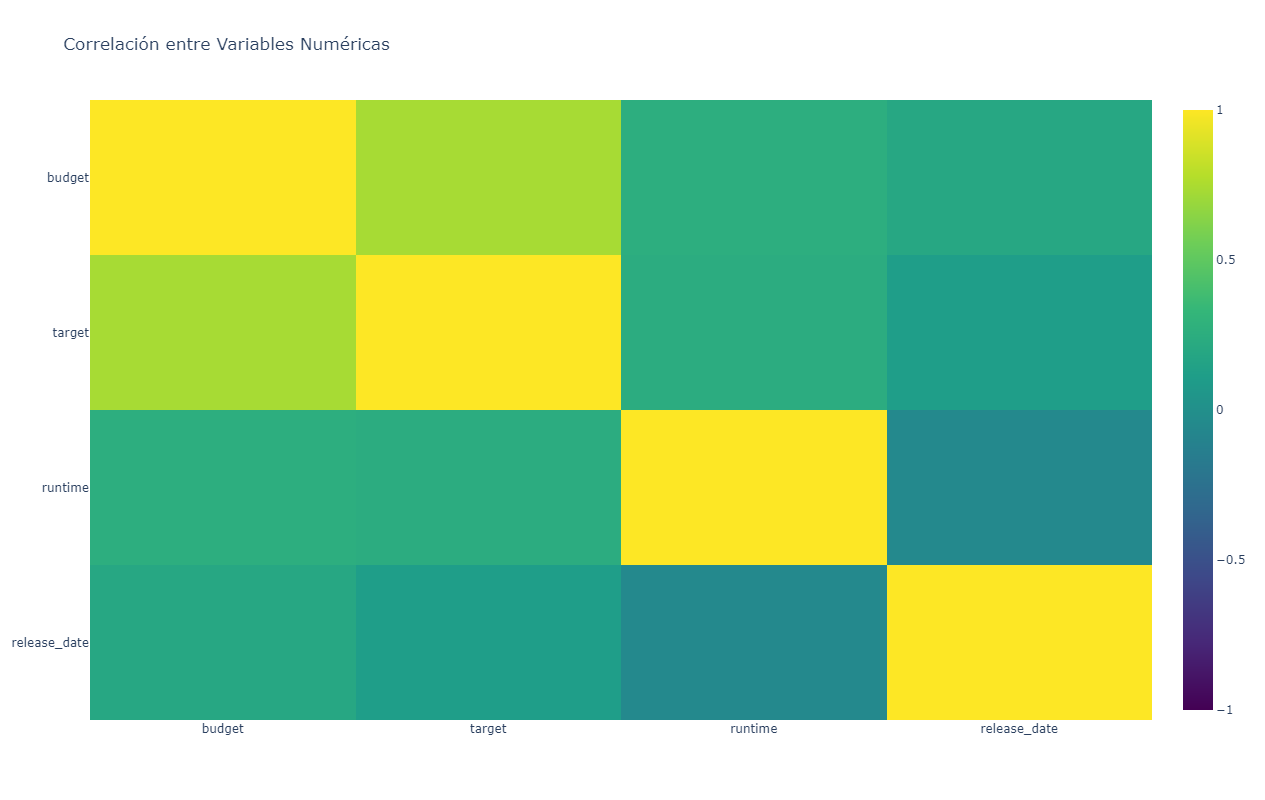

In [19]:
px.imshow(
    corrmat,
    aspect="16:9",
    title="Correlación entre Variables Numéricas",
    height=800,
    zmin=-1,
    color_continuous_midpoint=0,
    zmax=1,
    color_continuous_scale=px.colors.sequential.Viridis,
)

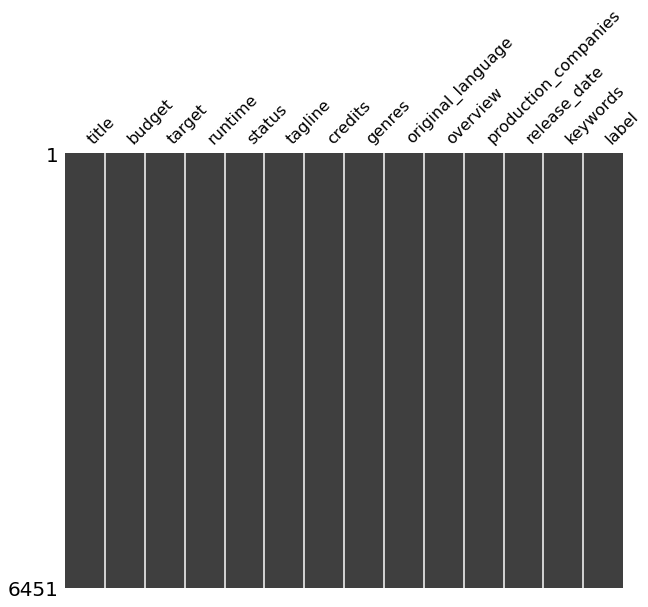

In [20]:
fig, ax = plt.subplots(figsize=[10, 8])

msno.matrix(df, ax=ax, sparkline=False)
plt.show()

#### Comentarios

- Como se sospechaba del scatter plot matrix, se presenta una alta correlación entre "budget" y "target". Además cada una presenta una leve correlación positiva con "runtime" y "release_date".

- Las variables "runtime" y "release_date" presentan entre ellas una correlación casi nula (-0.05).

- La Nulity Matrix reportada indica que no se observan valores faltantes, por lo que no se cuentan con datos para presentar un mapa de calor respectivo.

### Proyección en 2D de las variables numéricas mediante UMAP

In [21]:
import umap
df_scaled = MinMaxScaler().fit_transform(df_num)
umap = umap.UMAP(random_state = 4)
df_umap_embedded = umap.fit_transform(df_scaled)

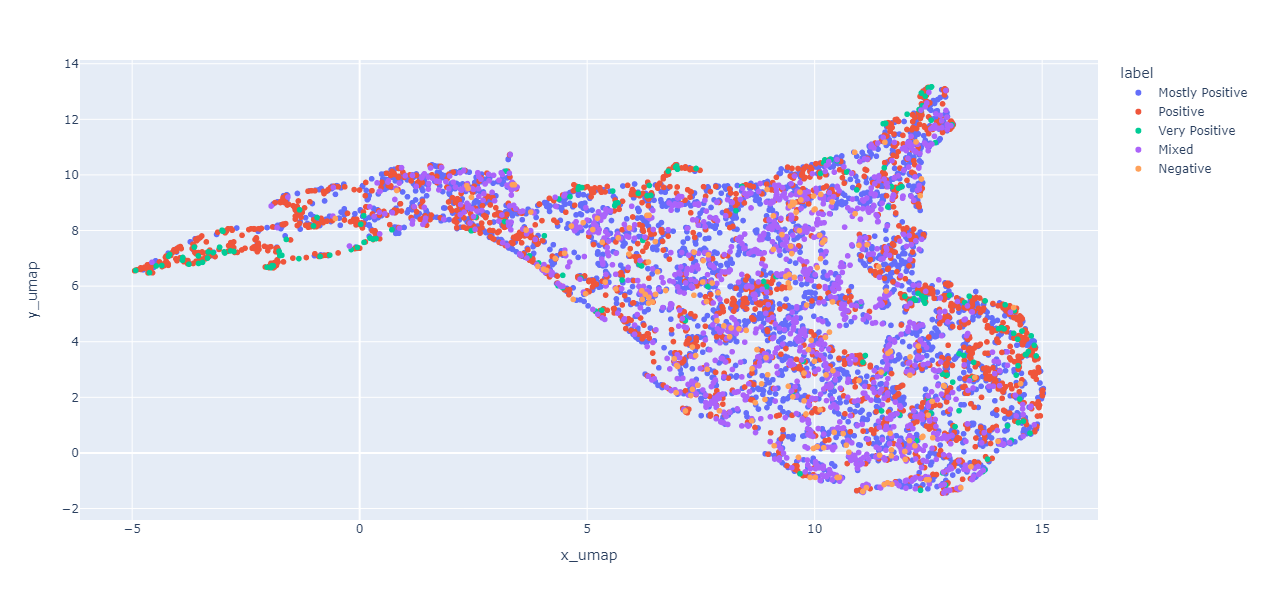

In [22]:
df_aux = df.copy()
df_aux["x_umap"] = df_umap_embedded[:, 0]
df_aux["y_umap"] = df_umap_embedded[:, 1]
px.scatter(df_aux, x="x_umap", y="y_umap", color='label',height=600)

#### Comportamientos Apreciables

- Se pueden observar algunas agrupaciones de etiquetas "positive" y "very positive", por ejemplo, en áreas a la izquierda y sector derecho del gráfico.

- Las películas etiquetadas como "mixed" y "mostly positive" se encuentran dispersas en las áreas centrales de la figura. Se pueden observar algunos grupos de "positive" al centro, pero los "very positive" en cambio escasean en el centro.

- Las películas etiquetadas como "negative" se encuentran en su mayoría dispersas, y casi no se observan agrupadas. Se aprecia que éstas se ubican en la región central de la figura, presentándose como un área casi complementaria del área que ocupan las películas "very positive".

### Scatterplot de budget vs target.

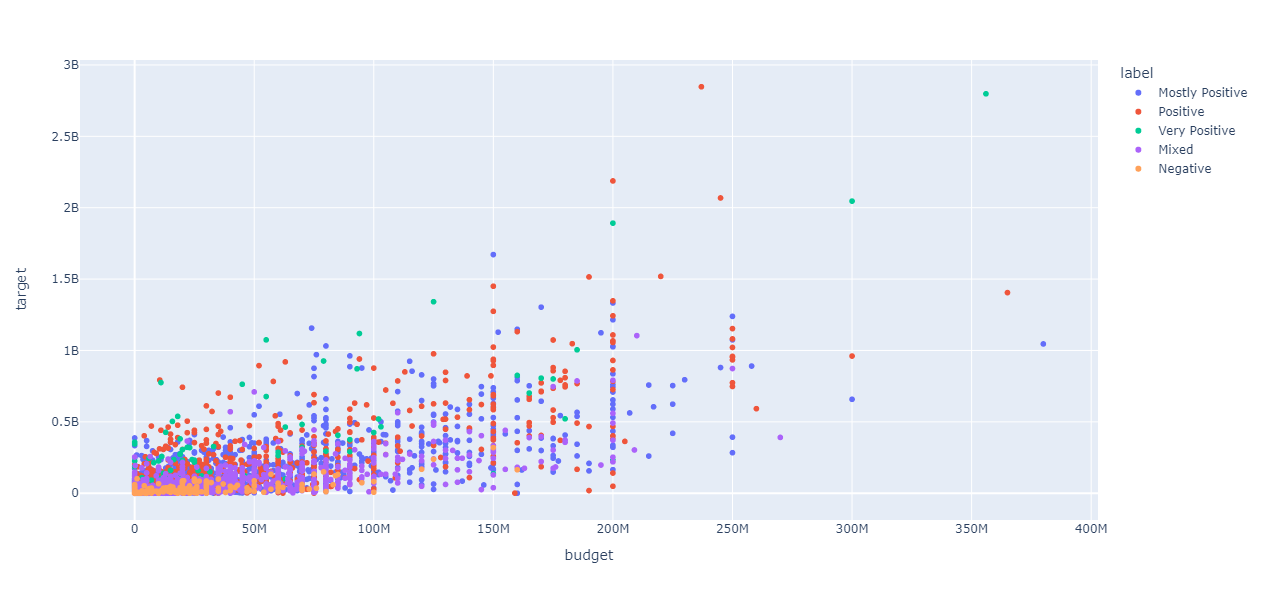

In [23]:
px.scatter(df, x="budget", y="target", height=600, color="label")

#### Comentarios

- Se aprecia una alta concentración de películas entre budget de 0 a 50 M y target de 0 a 0.5 B.
- Tal como se ha observado antes, se presenta un comportamiento de correlación positiva entre ambas variables.
- Se observa una concentración de películas "negative" en target bajo, a pesar que su distribución en budget no es limitada.

### Scatterplot de budget vs target: Películas de Marvel

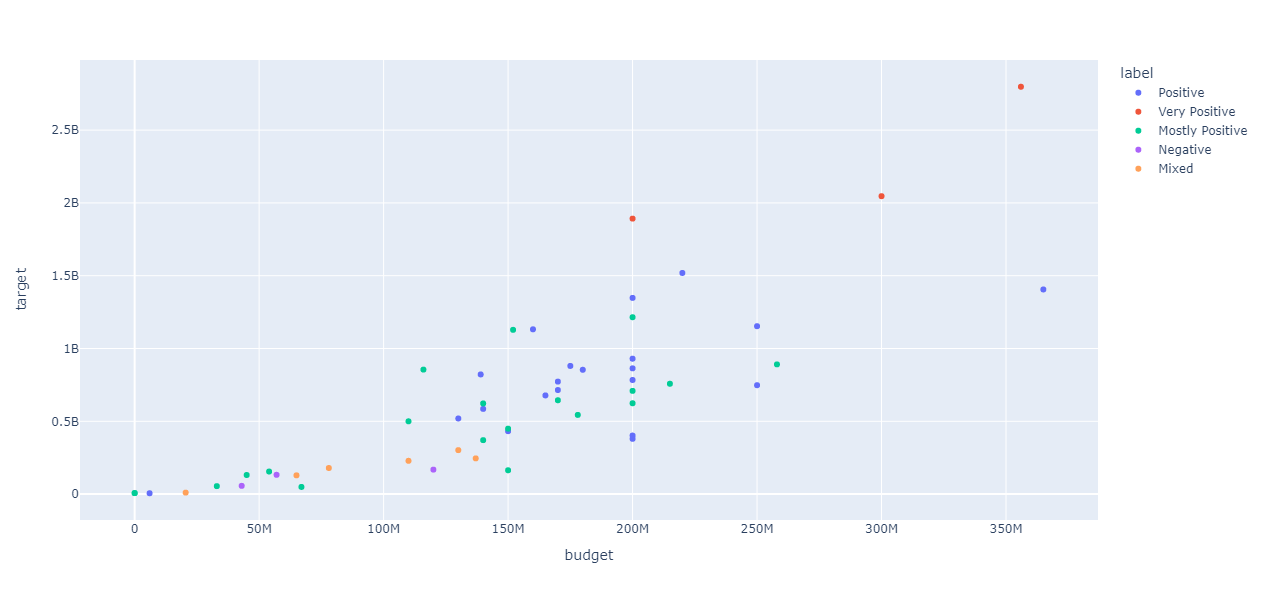

In [24]:
df_marvel = df[df['production_companies'].str.contains('Marvel')]
px.scatter(df_marvel, x="budget", y="target", height=600, hover_name = 'title', color="label")

#### Comentarios:

- En este caso, las películas se concentran en los budget 100M a 200M y 0.5 B a 1 B; cantidades mayores a las películas totales.
- Las películas con el mayor "budget" son de Avengers. De éstas, la que obtuvo el mayor target fue "Avengers: Endgame", aunque no tiene el mayor budget.
- Se observa que las películas mejor valoradas se encuentran con los mejores "target".
- Las películas que se encuentran abajo en target y budget puede deberse a que fueron hechas en otra época, como "transformers: the movie" u otras animadas como "ultimate avengers: the movie".

### Top 50 Productoras

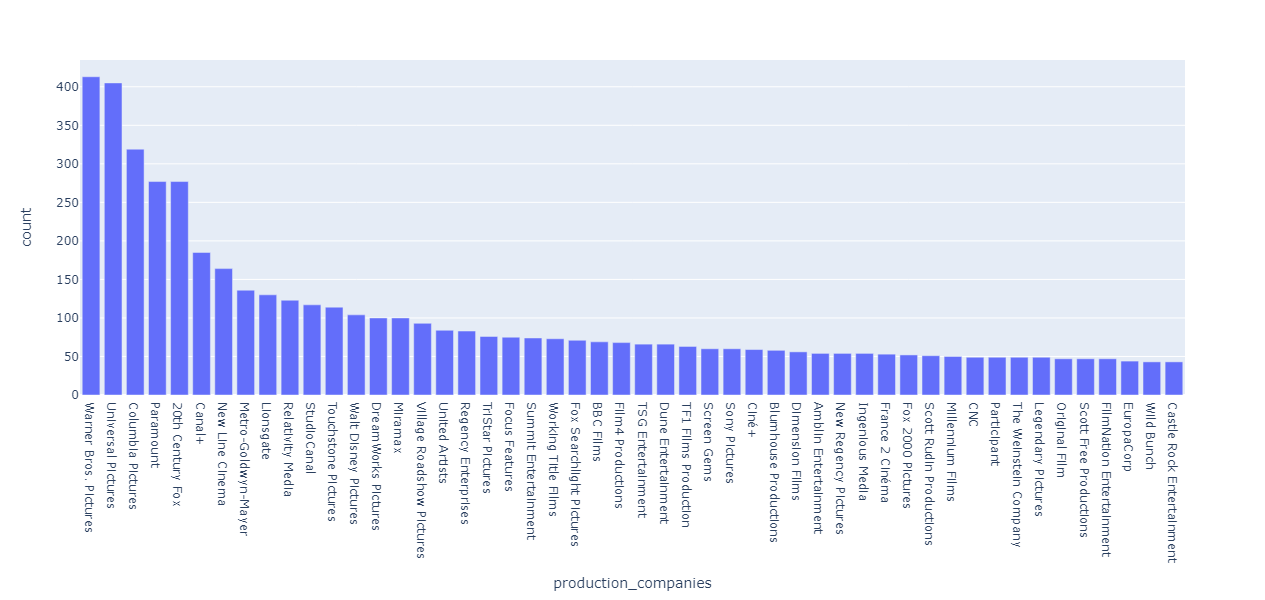

In [25]:
a = []
for i in df['production_companies'].unique():
    l = i.split('-')
    if 'Metro' in l:
        l.remove('Metro')
        l.remove('Goldwyn')
        l.remove('Mayer')
        l.append('Metro-Goldwyn-Mayer')
    a.append(l)
companies = np.array(sum(a,[]))
d = {}
for j in companies:
    if j not in d:
        d[j]=1
    else:
        d[j]+=1
comp_count = pd.DataFrame.from_dict(d, orient='index').reset_index().rename(columns={'index':'production_companies', 0:'count'})
comp_count_sorted = comp_count.sort_values(by='count', ascending=False)
px.bar(comp_count_sorted[:50], x='production_companies', y='count', height=600)

#### Comentarios:

- La distribución es alta en las primeras productoras, pero decrece rápidamente y posteriormente, a partir de la 15a productora, la cantidad de películas por productora decrece cada vez más lento.
- Las primeras 5 productoras son estadounidenses, y la 6ta es la primera que es de otro país, en este caso, francia.

Graficar a través de un gráfico de barras los 50 artistas más frecuentes.

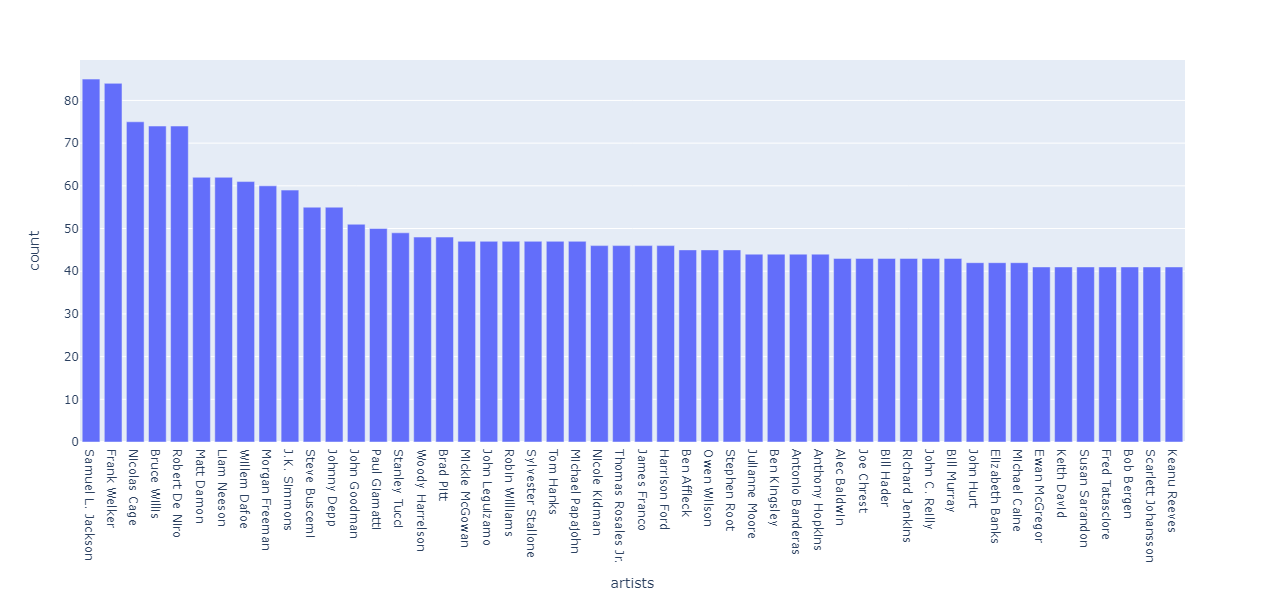

In [26]:
a = []
for i in df['credits'].unique():
    l = i.split('-')
    N = []
    for k in range(len(l)):
        if ' ' not in l[k]:
            N.append(l[k-1]+'-'+l[k])
        else:
            N.append(l[k])
    a.append(N)
artists = np.array(sum(a,[]))
d = {}
for j in artists:
    if j not in d:
        d[j]=1
    else:
        d[j]+=1
art_count = pd.DataFrame.from_dict(d, orient='index').reset_index().rename(columns={'index':'artists', 0:'count'})
art_count_sorted = art_count.sort_values(by='count', ascending=False)
px.bar(art_count_sorted[:50], x='artists', y='count', height=600)

#### Comentarios

- Se observa mayor uniformidad en la frecuencia de aparición de los artistas.
- A primera vista, se observa una mayoría de nombres escritos en inglés.
- Se aprecia una mayoría de nombres correspondientes a artistas masculinos.

### Pandas Profiling

In [27]:
#prof = ProfileReport(df)
#prof.to_file(output_file='output.html')

---

## 3. Conclusiones EDA

En esta parte del proyecto se ha podido explorar en detalle las variables que conforman el DataFrame. Se realizaron análisis univariados, que dieron cuenta de la forma y asimetrias de las distribuciones; y se realizaron análisis multivariados, que permitieron observar ciertas correlaciones positivas o nulas entre las distintas variables numéricas. Estos análisis se realizaron visualizando distintos gráficos, además de revisar las descripciones generadas por el reporte de "Pandas Profiling". Finalmente, se analizaron algunos casos particulares interesantes, como la dispersión en cuanto a "budget y "target" de las películas Marvel, y los top 50 productoras y top 50 artistas que presenta el DataFrame.

¿En que medida el EDA ayudó a comprender los datos en miras de generar un modelo predictivo?